# ***Assignment 3 for Data Analysis 3***

Conducted by Ian Brandenburg and Zsófia Rebeka Katona

[GitHub Repo](https://github.com/Iandrewburg/DA3_Brandenburg/tree/main/Assignment_3)



Developing a predictive model to identify which small or medium-sized firms in the "Manufacture of computer, electronic, and optical products" industry might fail in 2015, based on their activity in 2014.

[**Data source**](https://osf.io/b2ft9/?view_only=):
Detailed company data from a middle-sized country in the European Union
All registered companies in 2005-2016 in three selected industries 
  (auto manufacturing, equipment manufacturing, hotels and restaurants)
This rich database was constructed for from multiple publicly available sources 
by Bisnode, a business data and anlytics company www.bisnode.com
for educational purposes

Dependent Variable - Dummy Variable for if the company defaulted or not

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import os
from pathlib import Path
import sys
from plotnine import *
from mizani.formatters import percent_format
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Helper Functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# ***1. Data Processing***

## 1.1 Import Data Directly from GitHub

In [70]:
data = pd.read_csv('https://github.com/Iandrewburg/DA3_Brandenburg/raw/main/Assignment_3/cs_bisnode_panel.csv')
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [71]:
# Checking out the column names
data.columns

Index(['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod',
       'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories',
       'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales',
       'personnel_exp', 'profit_loss_year', 'sales', 'share_eq',
       'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind',
       'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg'],
      dtype='object')

In [72]:
# Checking out the info of the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

## 1.2 Data Cleaning

Missing values for a specific year (2014) and the entire dataset will be compared. 

In [73]:
# Filtering for 2014 data
data_2014 = data[(data['ind2'] == 26) &
                     (data['year'] == 2014)]
data_2014

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
969,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,0.0,...,male,Domestic,2630.0,26.0,2.0,2,East,1992-08-25,NaN,NaN
1128,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,0.0,...,female,Domestic,2651.0,26.0,2.0,1,Central,1995-08-28,NaN,0.083333
1342,1.089394e+07,2014-07-24,2014-12-31,NaN,0.000000,30614.814453,128055.546875,0.0,0.0,0.0,...,female,Domestic,2651.0,26.0,2.0,1,Central,2004-12-13,NaN,NaN
1467,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,0.0,...,male,Domestic,2660.0,26.0,2.0,2,Central,1991-06-27,NaN,0.083333
1593,1.571155e+07,2014-01-01,2014-12-31,NaN,0.000000,2477.777832,0.000000,0.0,0.0,0.0,...,NaN,NaN,2630.0,26.0,2.0,1,Central,2001-09-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286758,4.604901e+11,2014-01-01,2014-12-31,NaN,0.000000,33.333332,585.185181,0.0,0.0,0.0,...,male,Domestic,2640.0,26.0,2.0,2,East,2000-06-14,NaN,NaN
286890,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,0.0,...,male,Domestic,2620.0,26.0,2.0,3,Central,1997-12-10,NaN,0.166667
287204,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,0.0,...,male,Domestic,2630.0,26.0,2.0,1,Central,1996-12-30,NaN,0.250000
287272,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,0.0,...,male,mix,2611.0,26.0,2.0,2,East,2010-12-15,NaN,0.166667


In [74]:
# Comparing the missing values from the entire data set and data from 2014
data.isnull().sum()

comp_id                      0
begin                        0
end                          0
COGS                    269572
amort                     8040
curr_assets                131
curr_liab                  131
extra_exp                18529
extra_inc                18529
extra_profit_loss        17203
finished_prod           270344
fixed_assets               131
inc_bef_tax               7437
intang_assets              140
inventories                131
liq_assets                 131
material_exp              8040
net_dom_sales           269572
net_exp_sales           269572
personnel_exp             8040
profit_loss_year          9884
sales                     7437
share_eq                   131
subscribed_cap             131
tang_assets               1470
wages                   269846
D                       287829
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             56457
exit_yea

After reviewing the null values, COGS, finished production, net dom sale, net exp sales, and wages will most likely need to be dropped. 

The null values will need to be viewed for one specific year to get an understanding of null values where the company only iterates once in the dataframe.
This way the null values can be better interpreted. 

In [75]:
data_2014.isnull().sum()

comp_id                    0
begin                      0
end                        0
COGS                    1176
amort                      5
curr_assets                0
curr_liab                  0
extra_exp                  1
extra_inc                  1
extra_profit_loss          1
finished_prod           1178
fixed_assets               0
inc_bef_tax                1
intang_assets              0
inventories                0
liq_assets                 0
material_exp               5
net_dom_sales           1176
net_exp_sales           1176
personnel_exp              5
profit_loss_year           0
sales                      1
share_eq                   0
subscribed_cap             0
tang_assets                0
wages                   1179
D                       1317
balsheet_flag              0
balsheet_length            0
balsheet_notfullyear       0
year                       0
founded_year              58
exit_year               1276
ceo_count                 58
foreign       

Here, we can verify that `COGS`, `finished_prod`, `net_dom_sale`, `net_exp_sales`, and `wages` will need to be dropped from the analysis. 

`exit_year` and `exit date` can stay since not all companies are exiting, and we are trying to predict how many companies will exit.

The `D` column will also be dropped for it's high frequency of missing values

Also dropping `ind` column, as it does not serve any use in this specific project.

With `labor_avg` having such a high number of missing values, this column will also be dropped. 

In [76]:
# Dropping the columns with too many missing values in the original data
data = data.drop(columns = ['COGS',
                            'finished_prod',
                            'net_dom_sales',
                            'net_exp_sales',
                            'wages',
                            'D',
                            'ind',
                            'labor_avg'])

In [77]:
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

amort                  8040
curr_assets             131
curr_liab               131
extra_exp             18529
extra_inc             18529
extra_profit_loss     17203
fixed_assets            131
inc_bef_tax            7437
intang_assets           140
inventories             131
liq_assets              131
material_exp           8040
personnel_exp          8040
profit_loss_year       9884
sales                  7437
share_eq                131
subscribed_cap          131
tang_assets            1470
founded_year          56457
exit_year            248970
ceo_count             56427
foreign               56427
female                56427
birth_year           111818
inoffice_days         56427
gender                56427
origin                56427
nace_main              1038
ind2                   1038
region_m                840
founded_date             51
exit_date            231649
dtype: int64

In [78]:
# Dropping the columns with too many missing values from the 2014 data
data_2014 = data_2014.drop(columns = ['COGS',
                                      'finished_prod',
                                      'net_dom_sales',
                                      'net_exp_sales',
                                      'wages',
                                      'D',
                                      'ind'])

In [79]:
to_filter_2014 = data_2014.isnull().sum()
to_filter_2014[to_filter_2014 > 0]

amort                   5
extra_exp               1
extra_inc               1
extra_profit_loss       1
inc_bef_tax             1
material_exp            5
personnel_exp           5
sales                   1
founded_year           58
exit_year            1276
ceo_count              58
foreign                58
female                 58
birth_year            210
inoffice_days          58
gender                 58
origin                 58
region_m                3
exit_date            1268
labor_avg             521
dtype: int64

In [80]:
# Creating a function to handle missing values

def data_dish_washer(data):
    # Step 1: Fill specific columns with 0 in case of numerical values
    zero_fill_cols = ['amort',
                      'curr_assets',
                      'personnel_exp', 
                      'material_exp',
                      'liq_assets',
                      'inventories',
                      'intang_assets', 
                      'fixed_assets',
                      'extra_profit_loss',
                      'extra_inc',
                      'extra_exp', 
                      'curr_liab',
                      'tang_assets']
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)


    # Step 2: Fill missing values with median where it makes sense
    median_fill_cols = ['sales',
                        'profit_loss_year',
                        'inc_bef_tax', 
                        'share_eq',
                        'subscribed_cap']
    for col in median_fill_cols:
        data[col] = data[col].fillna(data[col].median())

    # Step 3: Change: Drop rows with missing values in specified categorical columns
    row_drops = ['nace_main',
                 'ind2',
                 'ceo_count', 
                 'foreign', 
                 'female',
                 'inoffice_days',
                 'gender',
                 'origin']
    data = data.dropna(subset=row_drops)

    # Step 4: Will missing regions with 'NaN'
    data['region_m'] = data['region_m'].fillna('NaN')

    # Step 5: Convert Date variables to datetime types
    datetime_columns = ['begin',
                        'end',
                        'founded_date',
                        'exit_date']
    for col in datetime_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Step 6: Verify Numeric Columns
    numeric_columns = ['year',
                       'founded_year',
                       'exit_year',
                       'birth_year']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    

    return data

In [81]:
# Transforming the Infinite values with NaNs in data
data = data.replace([np.inf, -np.inf], np.nan)

In [82]:
# Transforming the Infinite values with NaNs in data 2014
data_2014 = data_2014.replace([np.inf, -np.inf], np.nan)

In [83]:
data_dish_washer(data)

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,inoffice_days,gender,origin,nace_main,ind2,urban_m,region_m,founded_date,exit_date,sales_log
0,1.001034e+06,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,...,5686.5,mix,Domestic,5630.0,56.0,1,Central,1990-11-19,NaT,11.046959
1,1.001034e+06,2006-01-01,2006-12-31,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,...,5686.5,mix,Domestic,5630.0,56.0,1,Central,1990-11-19,NaT,11.076386
2,1.001034e+06,2007-01-01,2007-12-31,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,...,5686.5,mix,Domestic,5630.0,56.0,1,Central,1990-11-19,NaT,11.083695
3,1.001034e+06,2008-01-01,2008-12-31,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,...,5686.5,mix,Domestic,5630.0,56.0,1,Central,1990-11-19,NaT,11.265568
4,1.001034e+06,2009-01-01,2009-12-31,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,...,5686.5,mix,Domestic,5630.0,56.0,1,Central,1990-11-19,NaT,10.723045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287823,4.641209e+11,2010-01-01,2010-12-31,0.000000,1781.481445,0.000000,0.0,0.0,0.0,0.000000,...,8187.0,female,Domestic,5510.0,55.0,2,East,1990-08-22,NaT,5.561678
287824,4.641209e+11,2011-01-01,2011-12-31,0.000000,1807.407349,3.703704,0.0,0.0,0.0,0.000000,...,8187.0,female,Domestic,5510.0,55.0,2,East,1990-08-22,NaT,5.669498
287825,4.641209e+11,2012-01-01,2012-12-31,0.000000,1518.518555,96.296295,0.0,0.0,0.0,0.000000,...,8187.0,female,Domestic,5510.0,55.0,2,East,1990-08-22,NaT,0.000000
287827,4.641209e+11,2014-01-01,2014-12-31,0.000000,644.444458,233.333328,0.0,0.0,0.0,0.000000,...,1441.0,female,Domestic,5510.0,55.0,2,East,1990-08-22,NaT,0.000000


In [84]:
data.columns

Index(['comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'tang_assets', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year',
       'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year',
       'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'urban_m',
       'region_m', 'founded_date', 'exit_date'],
      dtype='object')

In [65]:
data.isnull().sum()

year                 0
comp_id              0
begin                0
end                  0
amort                0
                    ..
flag_high_ceo_age    0
flag_miss_ceo_age    0
ceo_young            0
default_f            0
sales_mil_log_sq     0
Length: 110, dtype: int64

In [66]:
data.dtypes

year                    int64
comp_id               float64
begin                  object
end                    object
amort                 float64
                       ...   
flag_high_ceo_age       int32
flag_miss_ceo_age       int32
ceo_young               int32
default_f            category
sales_mil_log_sq      float64
Length: 110, dtype: object

In [68]:
data.sales_log

AttributeError: 'DataFrame' object has no attribute 'sales_log'

## 1.3 Label Engineering

In [19]:
# Adding all the missing year and comp_id combinations -
# Originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [20]:
# Generate status_alive; if sales are larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


<Axes: >

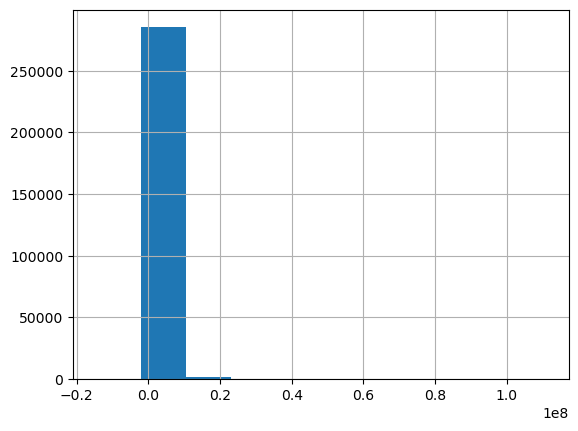

In [21]:
data.sales.hist()

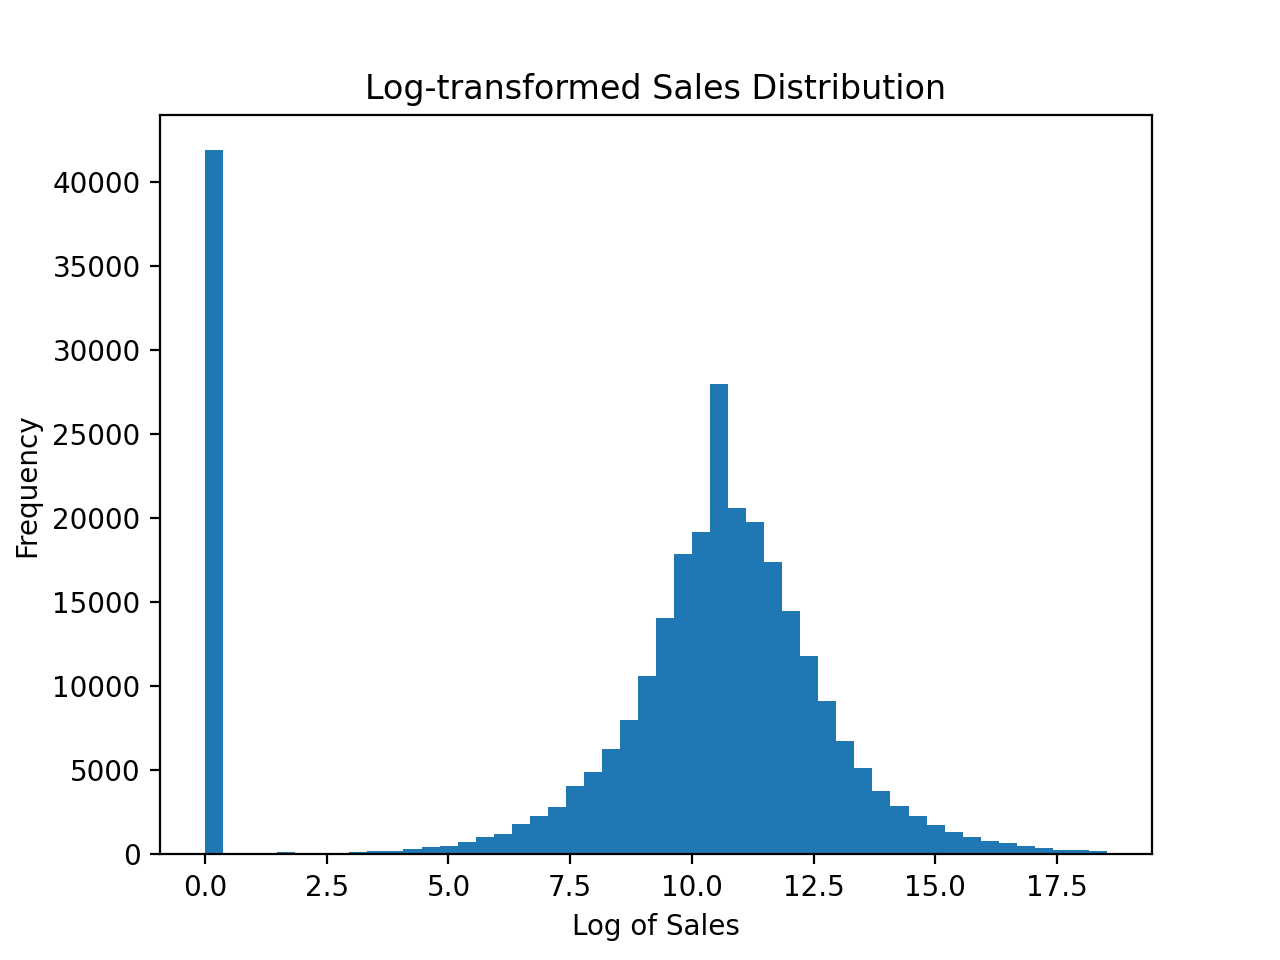

In [105]:
# Apply log transformation to sales data
data['sales_log'] = np.log1p(data['sales'])
plt.hist(data['sales_log'], bins=50)
plt.xlabel('Log of Sales')
plt.ylabel('Frequency')
plt.title('Log-transformed Sales Distribution')
plt.show()


In [22]:
data['default'].describe()

count    556944.000000
mean          0.093417
std           0.291016
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [23]:
data['status_alive'].value_counts()

status_alive
0    311016
1    245928
Name: count, dtype: int64

This concludes that there are 318,453 firms will default and 238,491 firms will stay alive.

In [24]:
data['sales'].describe()

count    2.878290e+05
mean     4.920700e+05
std      3.812404e+06
min     -1.472559e+07
25%      5.788889e+03
50%      3.280741e+04
75%      1.161481e+05
max      1.110294e+08
Name: sales, dtype: float64

In [25]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [26]:
# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


In [27]:
# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [28]:
data['new'].describe()

count    556944.000000
mean          0.672958
std           0.469133
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

This concludes that there are 556,944 new firms.

## 1.4 Sample Design


In [29]:
# Looking at cross section
data = data.query("year==2012 & status_alive == 1")
# Looking at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

## 1.5 Feature Engineering

In [30]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [31]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       53
26.0     1106
27.0      678
28.0     2001
29.0      290
30.0      176
32.0      152
33.0     1986
40.0      225
55.0     2385
56.0    13437
60.0      252
99.0        5
Name: comp_id, dtype: int64

In [32]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [33]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    22730
1.0       16
Name: comp_id, dtype: int64

In [34]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [35]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.274600e+04
mean     2.420035e+05
std      1.352734e+06
min      0.000000e+00
25%      5.496296e+03
50%      2.149815e+04
75%      8.724260e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [36]:
# profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']
# balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

In [37]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [38]:
for col in bs_names:
    # Create new column by dividing each specified column by total_assets_bs
    new_col_name = f"{col}_bs"  # This assumes bs_names does not already include "_bs"
    data[new_col_name] = data[col].div(data["total_assets_bs"]).replace((np.inf, -np.inf, np.nan), 0)
    
    # Set values to NaN where total_assets_bs is NaN
    data[new_col_name] = np.where(data["total_assets_bs"].isna(), np.nan, data[new_col_name])


In [39]:
for col in bs_names:
    # Create new column by dividing each specified column by total_assets_bs
    new_col_name = f"{col}_bs"  # This assumes bs_names does not already include "_bs"
    # Directly assign the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        np.nan,  # If total_assets_bs is NaN, assign NaN
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)  # Else, perform division and replace infinities
    )


In [40]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )
    

In [41]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [42]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [43]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [44]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [50]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [51]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

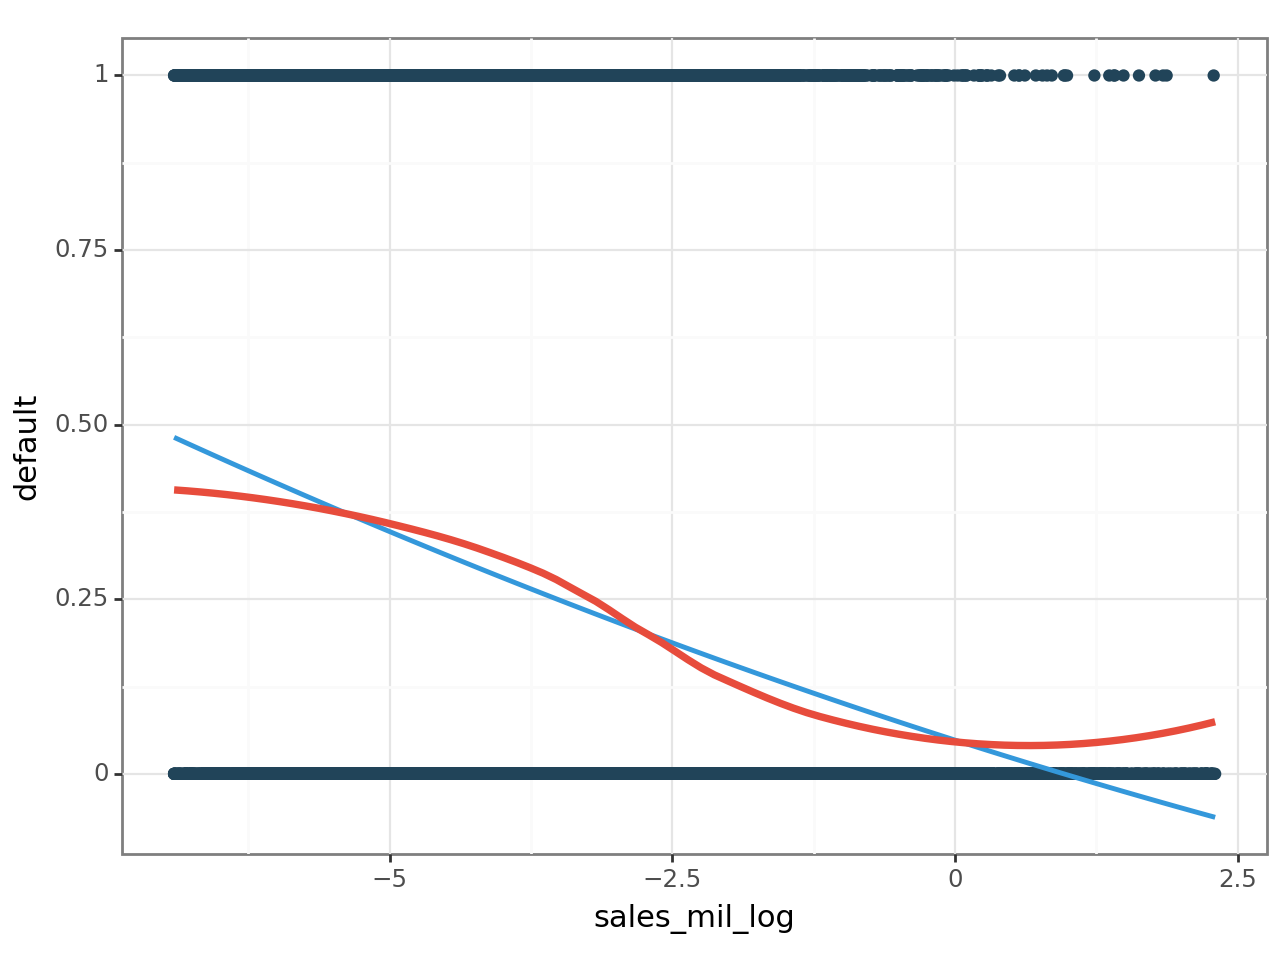

<Figure Size: (640 x 480)>

In [52]:
ggplot(data, aes(x="sales_mil_log", y="default")) + geom_point(
    color="#214459"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color="#3498db", se=False  # Assuming #3498db as a placeholder color
) + geom_smooth(
    method="loess", color="#e74c3c", se=False, size=1.5, span=0.9  # Assuming #e74c3c as a placeholder color
) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()


In [53]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     709.8
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          9.24e-300
Time:                        22:40:32   Log-Likelihood:                -11885.
No. Observations:               22746   AIC:                         2.378e+04
Df Residuals:                   22743   BIC:                         2.380e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0483      0.007  

In [54]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count    22746.000000
mean        -0.088826
std          0.890333
min         -6.889406
25%         -0.155711
50%          0.000000
75%          0.096553
max          9.089076
Name: d1_sales_mil_log, dtype: float64

## Model Building

### Define Variable Sets

Main Firm Variables

In [85]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [87]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

Flag Variables

In [88]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth Variables

In [89]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [90]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [92]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [94]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

### Model Setups

1. Simple Logit Models

In [95]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. Logit+LASSO

In [96]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [98]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## 1.6 Hold-Out Sample

In [55]:
hold_out_sample = data[(data['ind2'] == 26) &
                     (data['sales'] >= 1000) &
                     (data['sales'] <= 10000000) &
                     (data['year'] == 2014)]
hold_out_sample

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq


In [56]:
hold_out_sample.columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss',
       ...
       'inc_bef_tax_pl_quad', 'profit_loss_year_pl_quad', 'share_eq_bs_quad',
       'ceo_age', 'flag_low_ceo_age', 'flag_high_ceo_age', 'flag_miss_ceo_age',
       'ceo_young', 'default_f', 'sales_mil_log_sq'],
      dtype='object', length=110)

In [57]:
# double check missing values
missing_values_count = hold_out_sample.isnull().sum()

missing_values_table = pd.DataFrame(missing_values_count, columns=['Missing Values'])

missing_values_table

,Missing Values
year,0
comp_id,0
begin,0
end,0
amort,0
...,...
flag_high_ceo_age,0
flag_miss_ceo_age,0
ceo_young,0
default_f,0


In [58]:
hold_out_sample['default'].value_counts()

Series([], Name: count, dtype: int64)

In [59]:
hold_out_sample['sales'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sales, dtype: float64